### About
Multiclass classification of 37 breeds of cats and dogs using the [Oxford Pets datset](http://www.robots.ox.ac.uk/~vgg/data/pets/).

Just for fun, I've deployed this model live, you can play with it [here](https://dnb-pets.onrender.com/). 

#### Accuracy
- Mine: 0.950306
- SOTA: ?

### Setup
Load the fastai libraries.

In [1]:
from fastai import *
from fastai.vision import *

### Data
Download the dataset and look at the file structure.  Use a function to generate English class names instead of the numbers that are in the the annotations files.

In [2]:
untar_data(URLs.PETS)

/usr/local/lib/python3.6/dist-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [3]:
path = Path('/root/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
Path(path/'images').ls()[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg')]

In [6]:
Path(path/'annotations').ls()[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/README'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt')]

In [7]:
train_df = pd.read_csv(path/'annotations/list.txt', sep=' ',
                       header=None, names=['image', 'class', 'species', 'breed'], skiprows=6)

In [8]:
train_df.head()

,image,class,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [9]:
len(train_df)

7349

In [10]:
# examine image sizes
xs = []
ys = []
for fname in os.listdir(path/'images'):
    if fname.endswith('.jpg'):
        img = open_image(path/f'images/{fname}')
        x, y = img.size
        xs.append(x)
        ys.append(y)

(array([1.900e+01, 1.210e+02, 4.480e+02, 4.330e+02, 1.933e+03, 1.890e+03, 2.350e+02, 2.227e+03, 1.000e+01, 2.300e+01,
        2.000e+00, 2.000e+00, 4.000e+00, 1.200e+01, 4.000e+00, 9.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 103.  ,  153.06,  203.12,  253.18, ..., 2455.82, 2505.88, 2555.94, 2606.  ]),
 <a list of 50 Patch objects>)

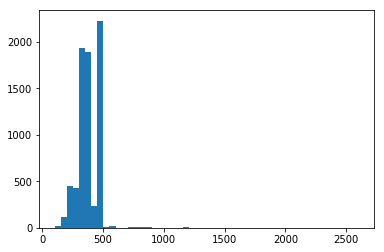

In [11]:
plt.hist(xs, bins=50)

(array([2.300e+01, 2.150e+02, 7.150e+02, 1.096e+03, 8.510e+02, 2.020e+02, 4.175e+03, 4.800e+01, 1.800e+01, 7.000e+00,
        7.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 8.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 114.,  177.,  240.,  303., ..., 3075., 3138., 3201., 3264.]),
 <a list of 50 Patch objects>)

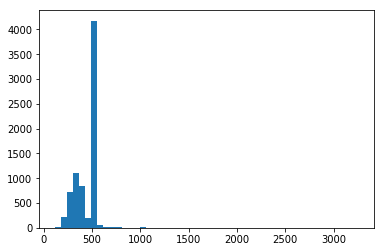

In [12]:
plt.hist(ys, bins=50)

### Model
Create the model.  Use a resnet pre-trained on imagenet.  Do all the affine and lighting transformation except for vertical flip.  I'm not sure why only 35 classes show up.  Maybe they merged some of the classes.

In [27]:
bs = 64
num_workers = 8
size = 299
model = models.resnet50

In [28]:
tfms = get_transforms()

In [29]:
def get_label(path):
    return Path(path).name.split('_')[0]

In [30]:
src = (ImageList.from_df(train_df, path/'images', suffix='.jpg')
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(get_label))

In [31]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

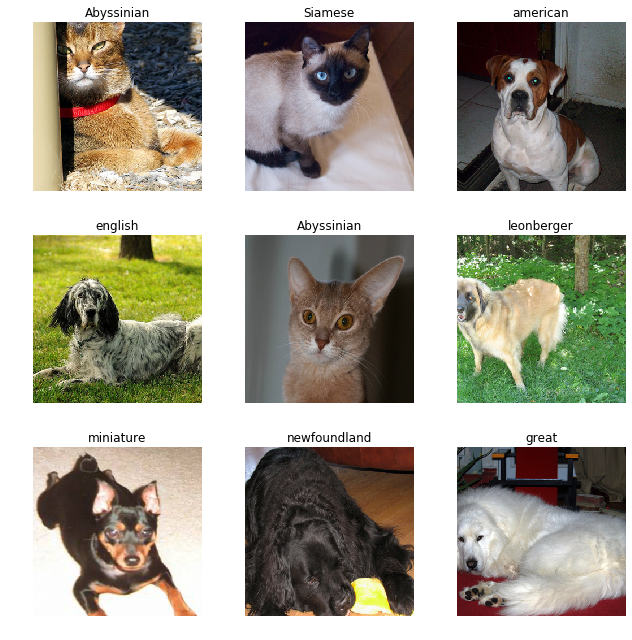

In [32]:
data.show_batch(3, figsize=(9, 9))

In [33]:
print(data.classes)
print(len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian', 'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx', 'american', 'basset', 'beagle', 'boxer', 'chihuahua', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'miniature', 'newfoundland', 'pomeranian', 'pug', 'saint', 'samoyed', 'scottish', 'shiba', 'staffordshire', 'wheaten', 'yorkshire']
35


In [34]:
learn = cnn_learner(data, model, metrics=[accuracy])

In [35]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________

### Train
Run the learning rate finder and train the model using 1-cycle learning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


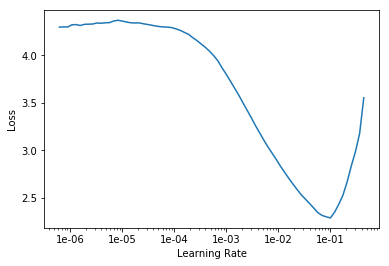

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.632605,0.430526,0.861811,00:51
1,0.738345,0.786138,0.763104,00:49
2,0.517416,0.369371,0.887679,00:48
3,0.319273,0.217516,0.923077,00:49
4,0.188046,0.187044,0.940776,00:49


In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


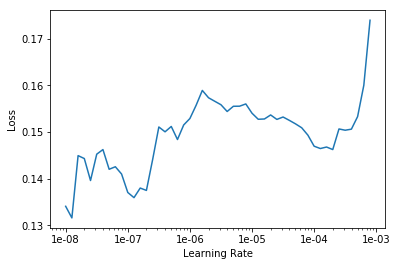

In [41]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(7, max_lr=slice(2e-6, 2e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.157472,0.182004,0.944180,01:05
1,0.150124,0.173918,0.944180,01:05
2,0.136203,0.166453,0.948945,01:05
3,0.130547,0.167328,0.948945,01:05
4,0.116427,0.164704,0.948945,01:05
5,0.107992,0.166386,0.950306,01:05
6,0.113673,0.163235,0.947583,01:05


### Results
Dig into the results by plotting top losses with an attention heatmap.

In [43]:
preds, targs, losses = learn.get_preds(with_loss=True)

In [44]:
interp = ClassificationInterpretation(learn, preds, targs, losses)

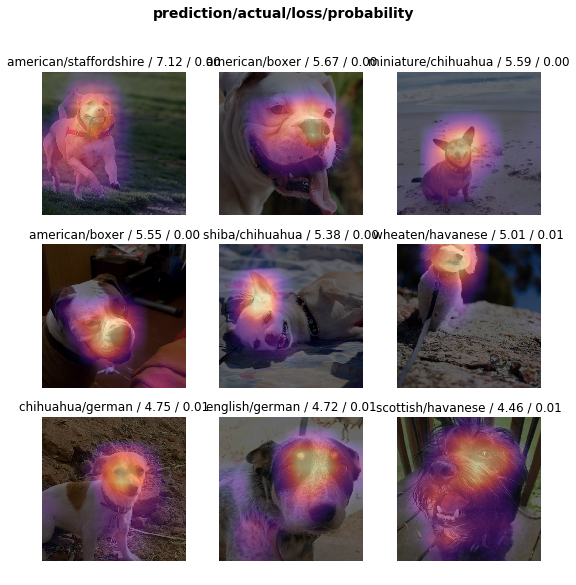

In [45]:
interp.plot_top_losses(9, figsize=(9, 9))

In [46]:
interp.most_confused(4)

[('staffordshire', 'american', 7),
 ('boxer', 'american', 5),
 ('Ragdoll', 'Birman', 4),
 ('Russian', 'British', 4)]

In [47]:
# total number of incorrect predictions
int(torch.sum(interp.pred_class != interp.y_true))

77